In [169]:
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from torchvision.datasets import ImageFolder
import sklearn.metrics as metrics
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [170]:
datasets = ["Caltech256","CIFAR10","DTD","MNIST"]
test_dypes = ["InD","InD"]
model_ls = ["Resnet18","Resnet50","Resnet101","EffNet_S","EffNet_M","EffNet_L"]
nrow, ncol=2,3
# pred_in_prefix = "../lp-ft/"
pred_in_prefix = "../lp-ft/cal_"
target_prefix = "../lp-ft/target_"
unc_out_prefix = "csv_lp-ft/uncertainty_"
pred_out_prefix = "csv_lp-ft/pred_"

In [171]:
dataset = datasets[0]
model = model_ls[5]
def soft_vote(pred_ls):
    sum_pred = np.sum(pred_ls,axis=0)
    return np.argmax(sum_pred,axis=1)
def soft_vote_top3(pred_ls):
    sum_pred = sum(pred_ls)
    return sum_pred.apply(lambda row: row.nlargest(3).index.tolist(), axis=1)
extract_int = lambda x: [int(i.split('_')[1]) for i in x]

In [172]:
for model in model_ls:
    df_ft = pd.read_csv(f"{pred_in_prefix}{dataset}_{model}_ft.csv")
    df_lp = pd.read_csv(f"{pred_in_prefix}{dataset}_{model}_lp.csv")
    # df_lp = pd.read_csv(f"{pred_in_prefix}{dataset}_{model}_lp_real.csv")
    label = pd.read_csv(f"{target_prefix}{dataset}.csv")
    prediction = pd.DataFrame({
        "pred_lp": df_lp.idxmax(axis=1),
        "pred_ft": df_ft.idxmax(axis=1),
        "softvote(lp,ft)": soft_vote([df_lp,df_ft]),
        "top_3_lp": df_lp.apply(lambda row: row.nlargest(3).index.tolist(), axis=1),
        "top_3_ft": df_ft.apply(lambda row: row.nlargest(3).index.tolist(), axis=1),
        "top_3_sv": soft_vote_top3([df_lp,df_ft]).apply(extract_int),
        "target": label["target"],
        })
    prediction["pred_lp"] = prediction["pred_lp"].str.extract('(\d+)').astype(int)
    prediction["pred_ft"] = prediction["pred_ft"].str.extract('(\d+)').astype(int)
    # prediction["softvote(lp,ft)"] = soft_vote([df_lp,df_ft])
    prediction["top_3_lp"] = prediction["top_3_lp"].apply(extract_int)#.tolist()
    prediction["top_3_ft"] = prediction["top_3_ft"].apply(extract_int)#.tolist()
    # prediction["top_3_sv"] = soft_vote_top3([df_lp,df_ft]).apply(extract_int)
    display(prediction.head(1))
    unc = pd.DataFrame()
    sv = (df_lp+df_ft)/2
    unc["entr_ft"] = utils.calc_entr_torch(df_ft)
    unc["entr_lp"] = utils.calc_entr_torch(df_lp)
    unc["entr_sv"] = utils.calc_entr_torch(sv)
    unc["ce_ft_lp"] = utils.calc_cross_entr_torch(df_ft,df_lp)
    unc["ce_sv_ft"] = utils.calc_cross_entr_torch(sv,df_ft)
    unc["entr_lp+entr_ft"] = unc["entr_ft"]+unc["entr_lp"]
    unc["entr_ft+ce_ft_lp"] = unc["entr_ft"]+unc["ce_ft_lp"]
    unc["entr_sv+ce_ft_lp"] = unc["entr_ft"]+unc["ce_ft_lp"]
    unc["entr_sv+ce_sv_ft"] = unc["entr_ft"]+unc["ce_sv_ft"]
    unc["entr_ft*ce_ft_lp"] = unc["entr_ft"]*unc["ce_ft_lp"]
    unc["js"] = unc["entr_sv"]-unc["entr_ft"]/2-unc["entr_lp"]/2
    unc["entr_sv+js"] = unc["entr_sv"]+ unc["js"]
    unc["entr_ft+js"] = unc["entr_ft"]+ unc["js"]
    prediction.to_csv(f"{pred_out_prefix}{dataset}_{model}.csv")
    unc.to_csv(f"{unc_out_prefix}{dataset}_{model}.csv")

,pred_lp,pred_ft,"softvote(lp,ft)",top_3_lp,top_3_ft,top_3_sv,target
0,233,141,233,"[233, 154, 38]","[141, 170, 38]","[233, 38, 154]",233


,pred_lp,pred_ft,"softvote(lp,ft)",top_3_lp,top_3_ft,top_3_sv,target
0,233,233,233,"[233, 155, 137]","[233, 124, 3]","[233, 124, 208]",233


,pred_lp,pred_ft,"softvote(lp,ft)",top_3_lp,top_3_ft,top_3_sv,target
0,233,233,233,"[233, 124, 179]","[233, 124, 207]","[233, 124, 179]",233


,pred_lp,pred_ft,"softvote(lp,ft)",top_3_lp,top_3_ft,top_3_sv,target
0,233,233,233,"[233, 207, 38]","[233, 207, 66]","[233, 207, 124]",233


,pred_lp,pred_ft,"softvote(lp,ft)",top_3_lp,top_3_ft,top_3_sv,target
0,233,141,233,"[233, 232, 124]","[141, 45, 251]","[233, 3, 124]",233


,pred_lp,pred_ft,"softvote(lp,ft)",top_3_lp,top_3_ft,top_3_sv,target
0,256,233,233,"[256, 250, 95]","[233, 124, 198]","[233, 29, 256]",233


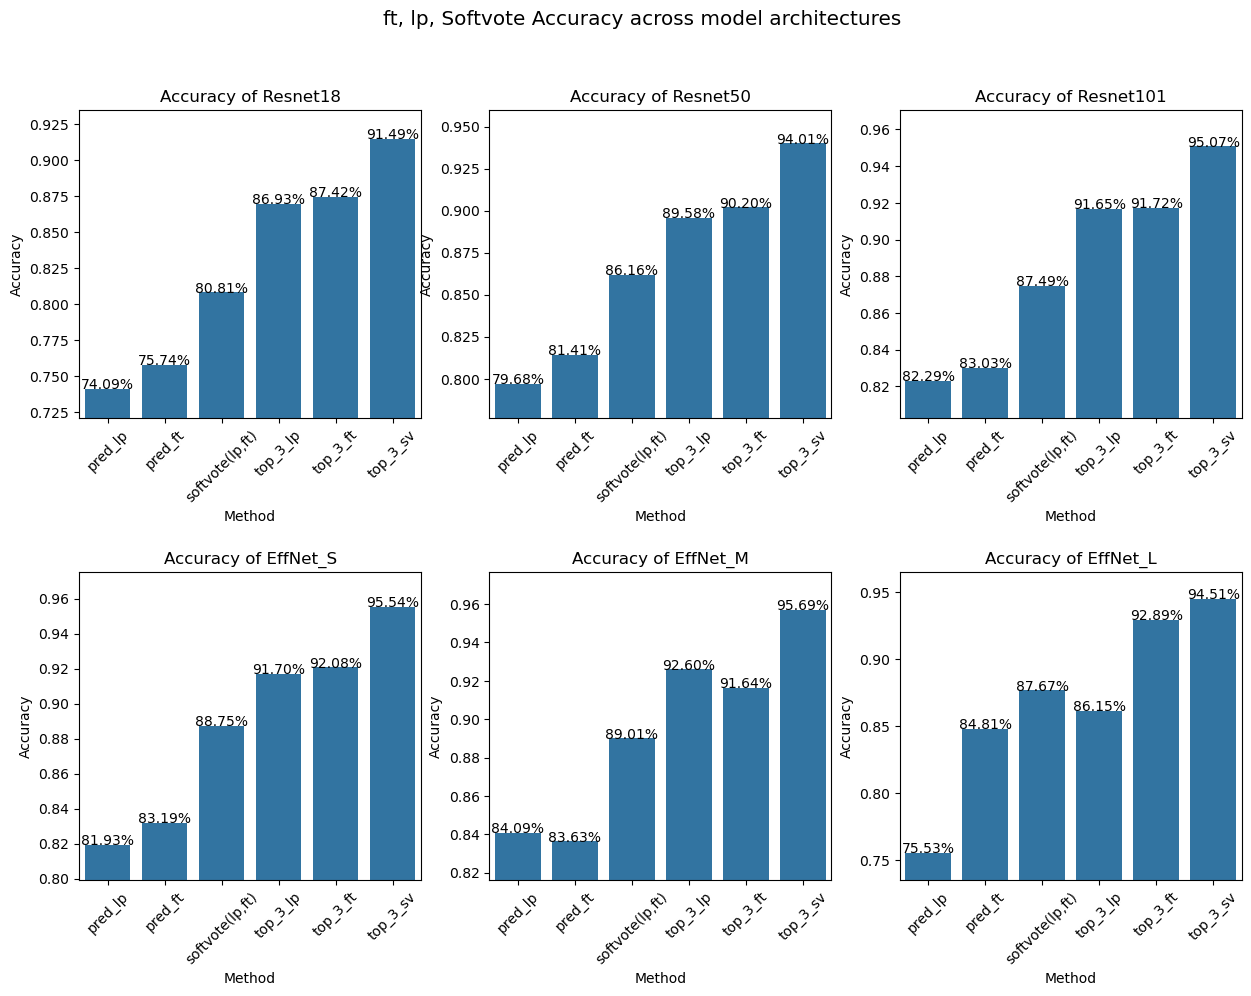

In [173]:
def eval_pred(pred):
    results = []
    for col in pred.columns.drop("target"):
        if isinstance(pred[col].iloc[0], str):
            acc = pred.apply(lambda row: str(row["target"]) in row[col], axis=1).mean()
        else:
            acc = (pred[col] == pred["target"]).mean()
        results.append({"Method": col, "Accuracy": acc})
    return pd.DataFrame(results)
def barplot_acc(pred, model, ax, margin = 0.02):
    pred = pd.read_csv(f"{pred_out_prefix}{dataset}_{model}.csv", index_col="Unnamed: 0")
    results_df = eval_pred(pred)
    sns.barplot(x='Method', y='Accuracy', data=results_df, ax=ax)
    
    for index, row in results_df.iterrows():
        ax.text(index, row['Accuracy'], f"{row['Accuracy']:.2%}", color='black', ha="center")
    
    ax.tick_params(axis='x', rotation=45)
    ax.set_title(f'Accuracy of {model}')
    ax.set_xlabel('Method')
    ax.set_ylabel('Accuracy')
    
    min_acc = results_df['Accuracy'].min()
    max_acc = results_df['Accuracy'].max()
    ax.set_ylim(min_acc - margin, min(1, max_acc + margin))
    
fig, axes = plt.subplots(nrow, ncol, figsize=(5*ncol, 5*nrow))
for i, model in enumerate(model_ls):
    ax = axes[i // ncol, i % ncol]
    barplot_acc(prediction,model,ax)
plt.subplots_adjust(hspace=0.5)
plt.suptitle(f"ft, lp, Softvote Accuracy across model architectures",fontsize = 'x-large')
plt.show()

In [174]:
def auroc(pred_df, unc_df, pred_vec, target_vec, unc_vec, ax):
    label = f"{unc_vec} on {pred_vec}"
    if isinstance(pred_df[pred_vec].iloc[0],str):
        is_correct = pred_df.apply(lambda row: str(row[target_vec]) not in row[pred_vec], axis=1)
    else:
        is_correct = pred_df[pred_vec]!=pred_df[target_vec]
    fpr, tpr, threshold = metrics.roc_curve(is_correct, unc_df[unc_vec])
    roc_auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, label = f'{label}: AUC = %0.3f' % roc_auc)
    ax.legend(loc = 'lower right')
    ax.plot([0, 1], [0, 1],'r--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

def weighted_sum_of_entropy(p, unc_df, entr1_col, entr2_col, pred_df, pred_col, target_col):
    if isinstance(pred_df[pred_col].iloc[0],str):
        is_correct = pred_df.apply(lambda row: str(row[target_col]) not in row[pred_col], axis=1)
    else:
        is_correct = pred_df[pred_col]!=pred_df[target_col]
    fpr, tpr, threshold = metrics.roc_curve(is_correct, p*unc_df[entr1_col]+(1-p)*unc_df[entr2_col])
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc
def explore_weighted_sum(n, unc_df, entr1_col, entr2_col, pred_df, pred_col, target_col, ax):
    p_ls = np.arange(n)/(n-1)
    auroc_ls = np.zeros(n)
    for i,p in enumerate(p_ls):
        auroc_ls[i]=weighted_sum_of_entropy(p, unc_df, entr1_col, entr2_col, pred_df, pred_col, target_col)
    temp_max = auroc_ls.max()
    temp_argmax = auroc_ls.argmax()
    sns.lineplot(x=p_ls,y=auroc_ls, label=f"max={temp_max:.3f}: {entr1_col} and {entr2_col} on {pred_col}", ax=ax)
    ax.set_ylabel('AUROC')
    ax.set_xlabel('p (weight to first unc measure)')
    return p_ls[temp_argmax]

def weighted_prod_of_entropy(p, unc_df, entr1_col, entr2_col, pred_df, pred_col, target_col):
    if isinstance(pred_df[pred_col].iloc[0],str):
        is_correct = pred_df.apply(lambda row: str(row[target_col]) not in row[pred_col], axis=1)
    else:
        is_correct = pred_df[pred_col]!=pred_df[target_col]
    fpr, tpr, threshold = metrics.roc_curve(is_correct, (unc_df[entr1_col]**p)*(unc_df[entr2_col]**(1-p)))
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

def explore_weighted_prod(n, unc_df, entr1_col, entr2_col, pred_df, pred_col, target_col, ax):
    p_ls = np.arange(n)/(n-1)
    auroc_ls = np.zeros(n)
    for i,p in enumerate(p_ls):
        auroc_ls[i]=weighted_prod_of_entropy(p, unc_df, entr1_col, entr2_col, pred_df, pred_col, target_col)
    temp_max = auroc_ls.max()
    temp_argmax = auroc_ls.argmax()
    sns.lineplot(x=p_ls,y=auroc_ls, label=f"max={temp_max:.3f}: {entr1_col} times {entr2_col} on {pred_col}", ax=ax)
    ax.set_ylabel('AUROC')
    ax.set_xlabel('p (weight to first unc measure)')
    return p_ls[temp_argmax]

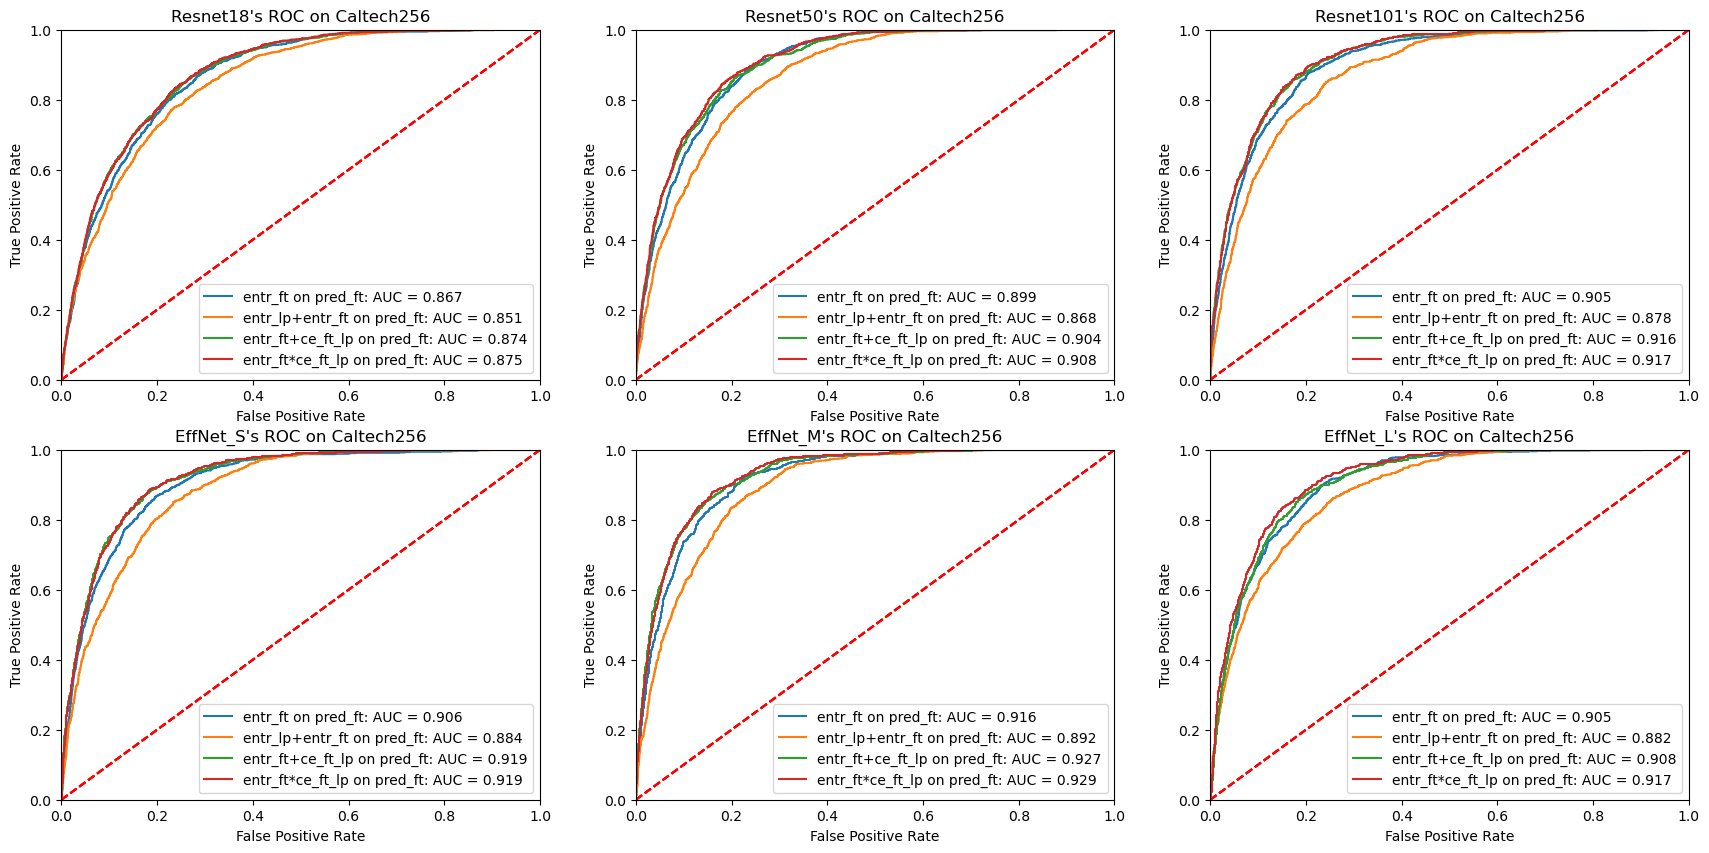

In [175]:
fig, axes = plt.subplots(nrow, ncol, figsize=(7*ncol, 5*nrow))
for i, model in enumerate(model_ls):
    pred_df = pd.read_csv(f"{pred_out_prefix}{dataset}_{model}.csv", index_col="Unnamed: 0")
    unc_df = pd.read_csv(f"{unc_out_prefix}{dataset}_{model}.csv", index_col="Unnamed: 0")
    ax = axes[i // ncol, i % ncol]
    ax.set_title(f"{model}'s ROC on {dataset}")
    auroc(pred_df, unc_df, "pred_ft", "target", "entr_ft", ax)
    # auroc(pred_df, unc_df, "pred_ft", "target", "ce_ft_lp", ax)
    # auroc(pred_df, unc_df, "pred_ft", "target", "entr_sv", ax)
    auroc(pred_df, unc_df, "pred_ft", "target", "entr_lp+entr_ft", ax)
    auroc(pred_df, unc_df, "pred_ft", "target", "entr_ft+ce_ft_lp", ax)
    auroc(pred_df, unc_df, "pred_ft", "target", "entr_ft*ce_ft_lp", ax)

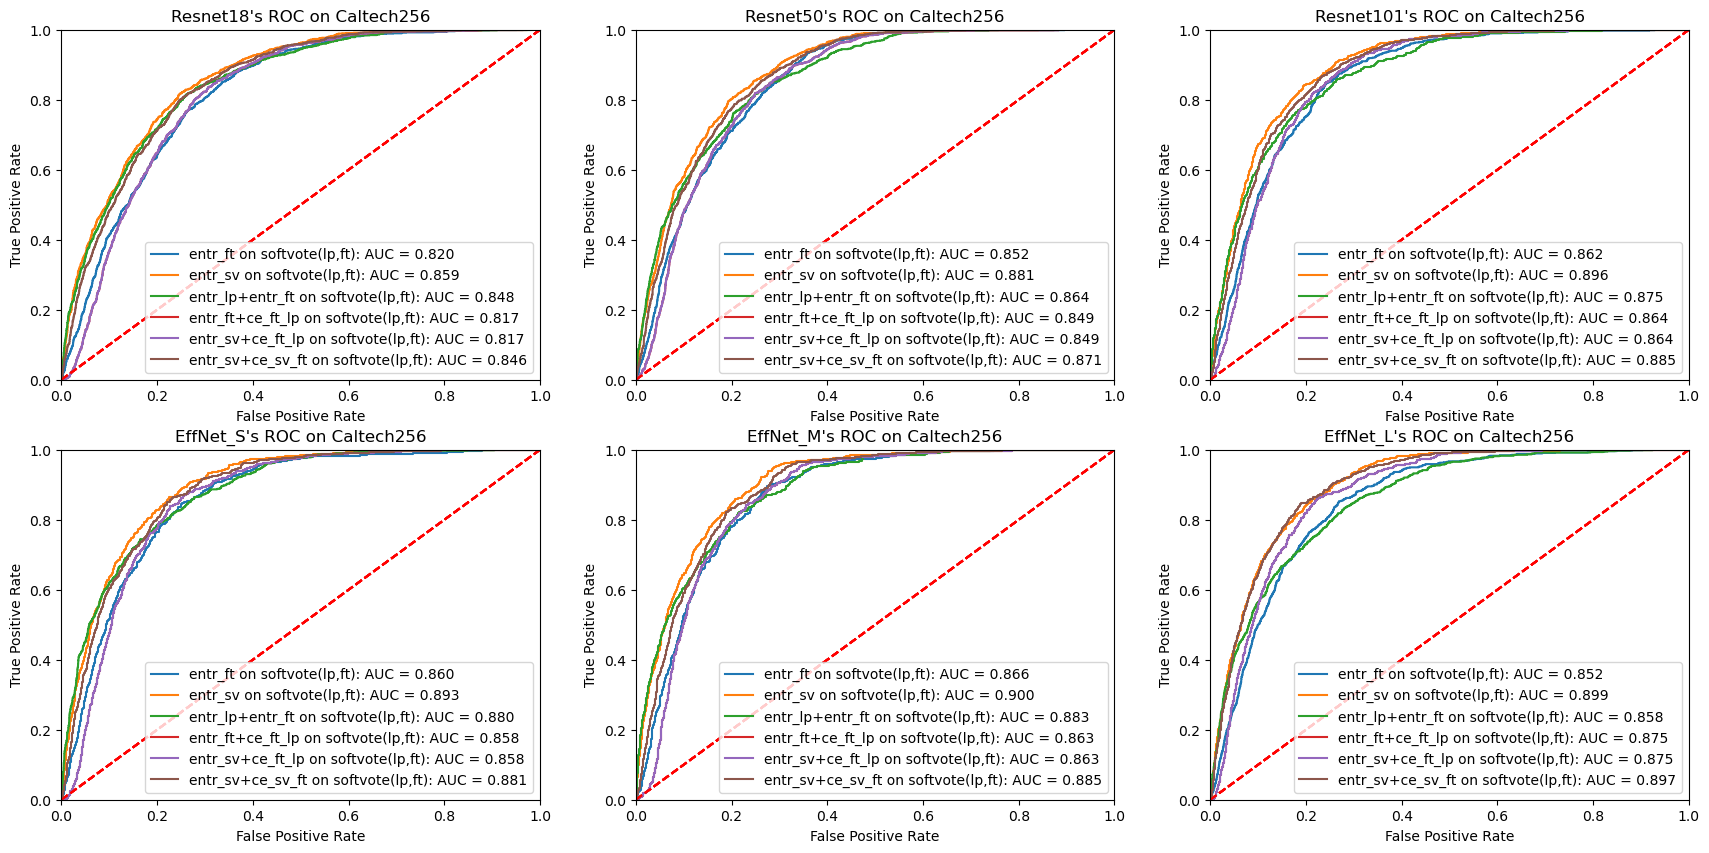

In [176]:
fig, axes = plt.subplots(nrow, ncol, figsize=(7*ncol, 5*nrow))
for i, model in enumerate(model_ls):
    pred_df = pd.read_csv(f"{pred_out_prefix}{dataset}_{model}.csv", index_col="Unnamed: 0")
    unc_df = pd.read_csv(f"{unc_out_prefix}{dataset}_{model}.csv", index_col="Unnamed: 0")
    ax = axes[i // ncol, i % ncol]
    ax.set_title(f"{model}'s ROC on {dataset}")
    auroc(pred_df, unc_df, "softvote(lp,ft)", "target", "entr_ft", ax)
    auroc(pred_df, unc_df, "softvote(lp,ft)", "target", "entr_sv", ax)
    # auroc(pred_df, unc_df, "softvote(lp,ft)", "target", "ce_ft_lp", ax)
    auroc(pred_df, unc_df, "softvote(lp,ft)", "target", "entr_lp+entr_ft", ax)
    auroc(pred_df, unc_df, "softvote(lp,ft)", "target", "entr_ft+ce_ft_lp", ax)
    # auroc(pred_df, unc_df, "softvote(lp,ft)", "target", "entr_ft*ce_ft_lp", ax)
    auroc(pred_df, unc_df, "softvote(lp,ft)", "target", "entr_sv+ce_ft_lp", ax)
    auroc(pred_df, unc_df, "softvote(lp,ft)", "target", "entr_sv+ce_sv_ft", ax)

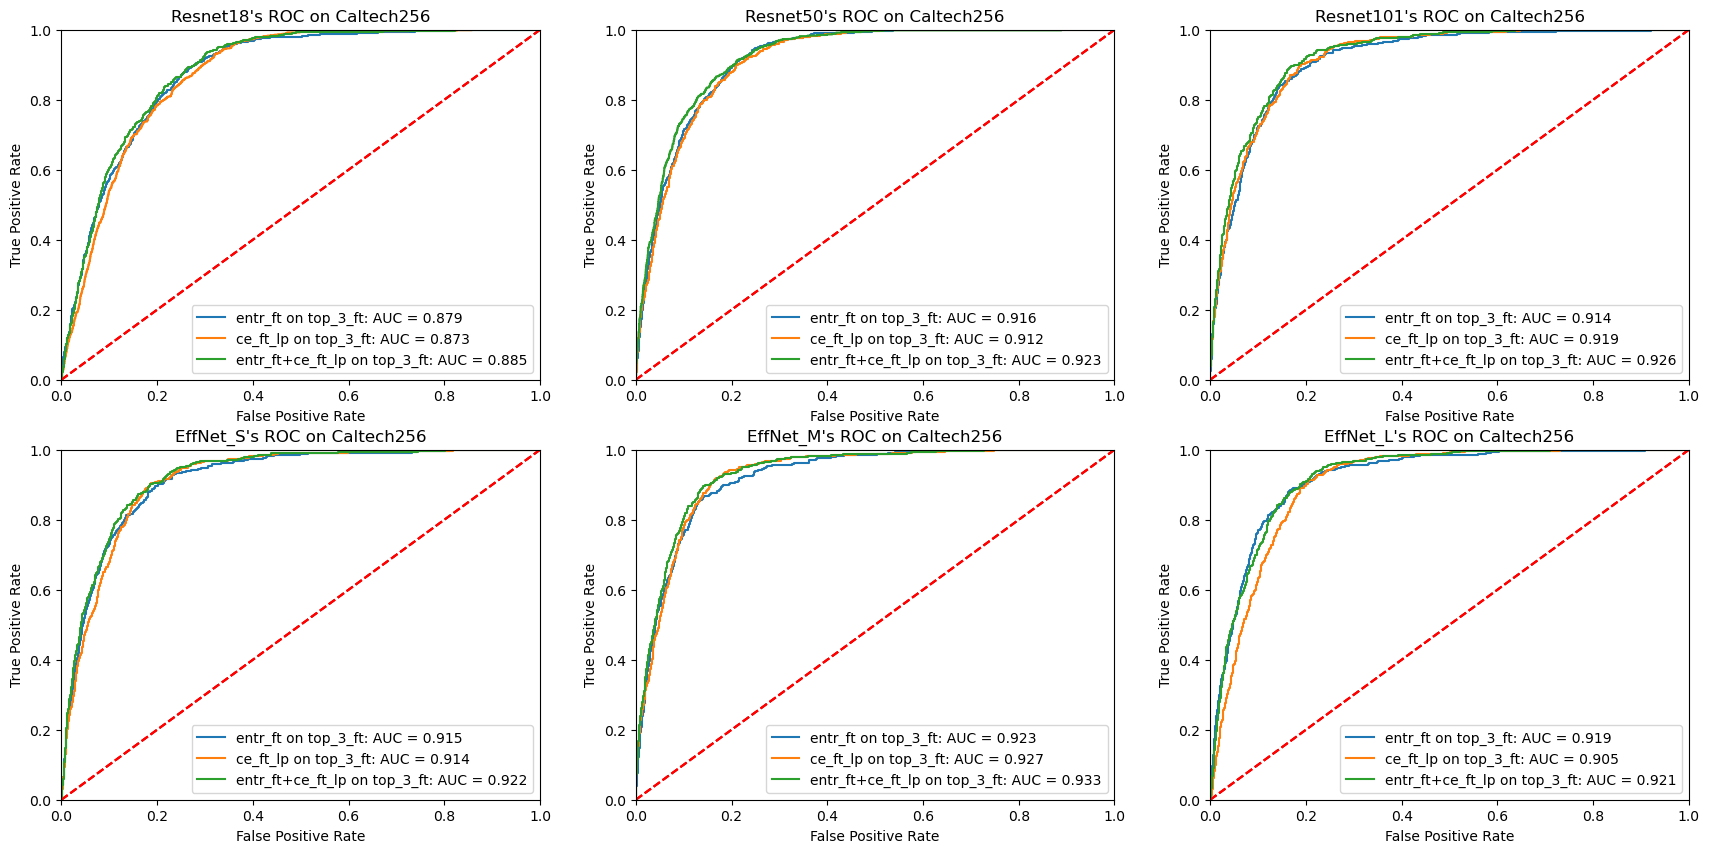

In [177]:
fig, axes = plt.subplots(nrow, ncol, figsize=(7*ncol, 5*nrow))
for i, model in enumerate(model_ls):
    pred_df = pd.read_csv(f"{pred_out_prefix}{dataset}_{model}.csv", index_col="Unnamed: 0")
    unc_df = pd.read_csv(f"{unc_out_prefix}{dataset}_{model}.csv", index_col="Unnamed: 0")
    ax = axes[i // ncol, i % ncol]
    ax.set_title(f"{model}'s ROC on {dataset}")
    auroc(pred_df, unc_df, "top_3_ft", "target", "entr_ft", ax)
    auroc(pred_df, unc_df, "top_3_ft", "target", "ce_ft_lp", ax)
    # auroc(pred_df, unc_df, "top_3_ft", "target", "entr_lp+entr_ft", ax)
    auroc(pred_df, unc_df, "top_3_ft", "target", "entr_ft+ce_ft_lp", ax)
    # auroc(pred_df, unc_df, "top_3_ft", "target", "entr_ft*ce_ft_lp", ax)

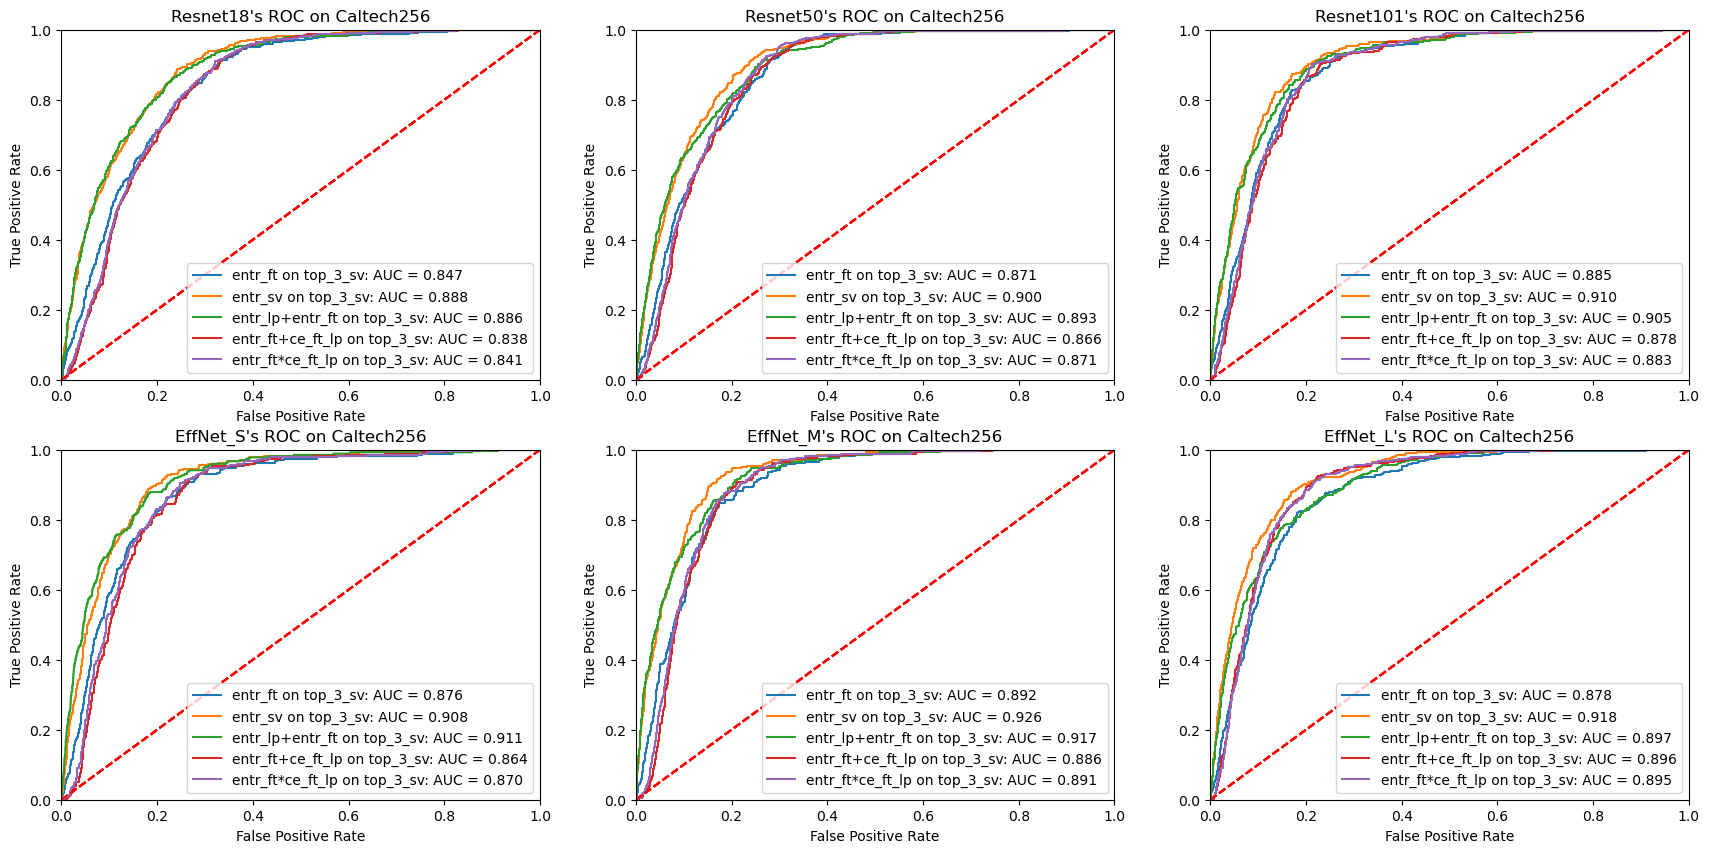

In [178]:
fig, axes = plt.subplots(nrow, ncol, figsize=(7*ncol, 5*nrow))
for i, model in enumerate(model_ls):
    pred_df = pd.read_csv(f"{pred_out_prefix}{dataset}_{model}.csv", index_col="Unnamed: 0")
    unc_df = pd.read_csv(f"{unc_out_prefix}{dataset}_{model}.csv", index_col="Unnamed: 0")
    ax = axes[i // ncol, i % ncol]
    ax.set_title(f"{model}'s ROC on {dataset}")
    auroc(pred_df, unc_df, "top_3_sv", "target", "entr_ft", ax)
    auroc(pred_df, unc_df, "top_3_sv", "target", "entr_sv", ax)
    # auroc(pred_df, unc_df, "top_3_sv", "target", "ce_ft_lp", ax)
    auroc(pred_df, unc_df, "top_3_sv", "target", "entr_lp+entr_ft", ax)
    auroc(pred_df, unc_df, "top_3_sv", "target", "entr_ft+ce_ft_lp", ax)
    auroc(pred_df, unc_df, "top_3_sv", "target", "entr_ft*ce_ft_lp", ax)

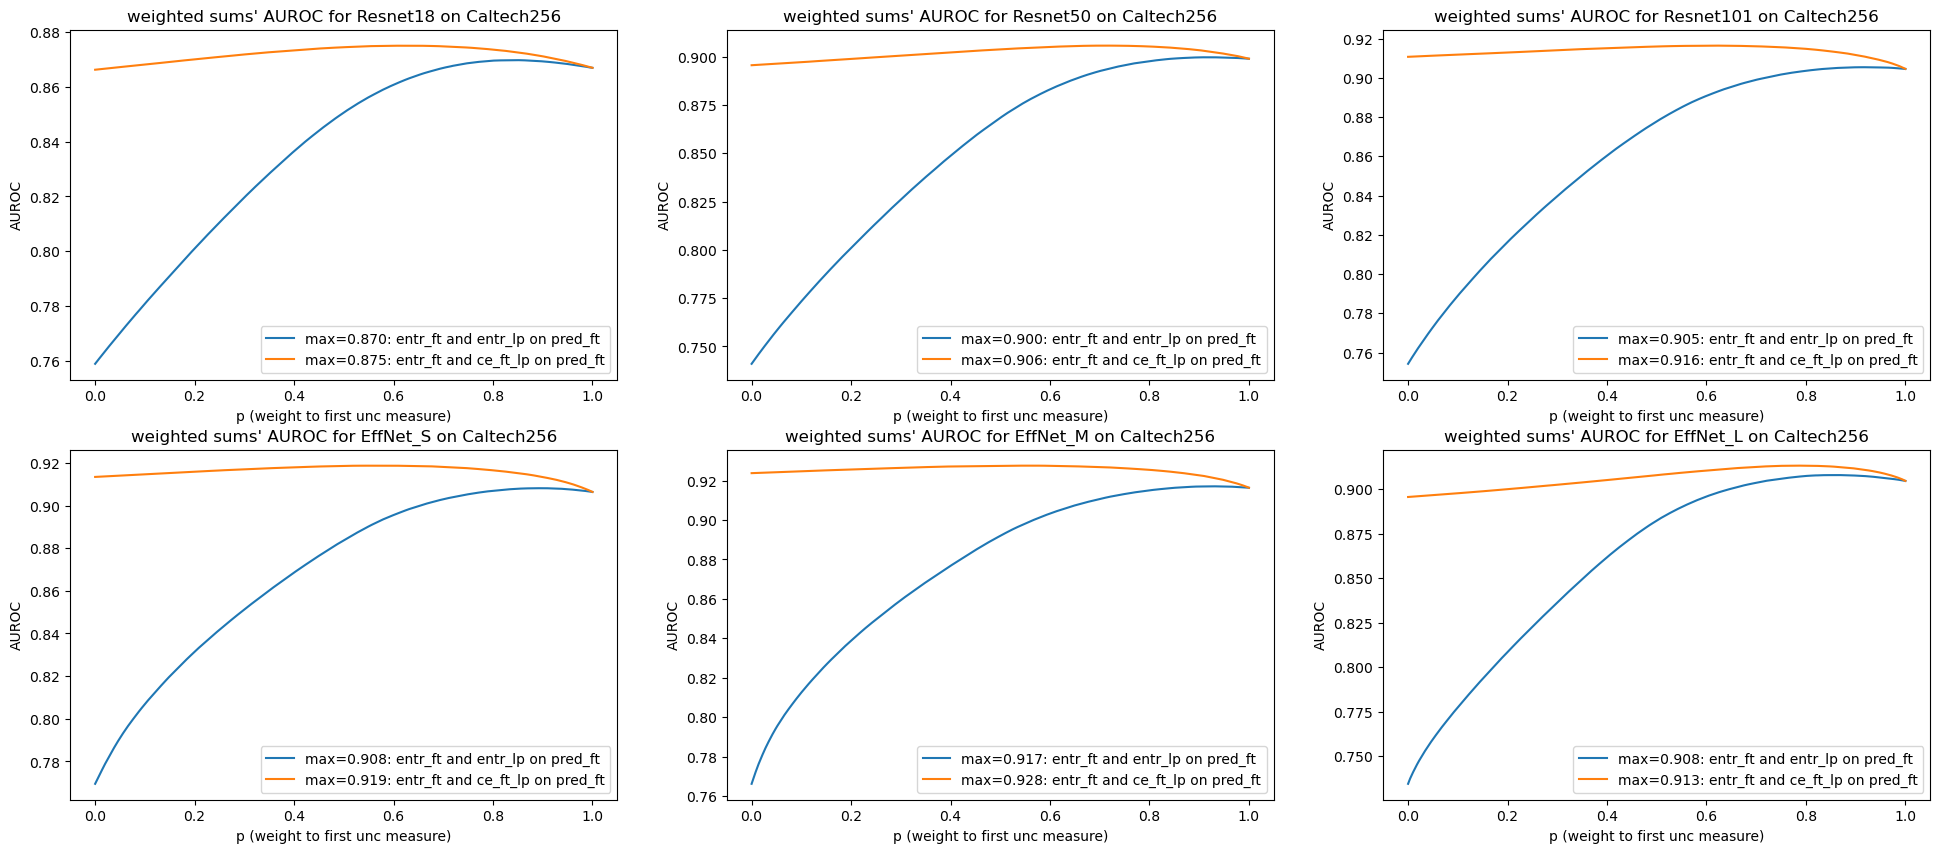

In [179]:
fig, axes = plt.subplots(nrow, ncol, figsize=(8*ncol, 5*nrow))
nsteps=500
for i, model in enumerate(model_ls):
    pred_df = pd.read_csv(f"{pred_out_prefix}{dataset}_{model}.csv", index_col="Unnamed: 0")
    unc_df = pd.read_csv(f"{unc_out_prefix}{dataset}_{model}.csv", index_col="Unnamed: 0")
    ax = axes[i // ncol, i % ncol]
    ax.set_title(f"weighted sums' AUROC for {model} on {dataset}")
    opt_p_predM = explore_weighted_sum(nsteps, unc_df, "entr_ft","entr_lp",pred_df,"pred_ft","target",ax)
    unc_df["opt_entr_ft_plus_entr_lp_for_pred_ft"] = opt_p_predM*unc_df['entr_ft']+(1-opt_p_predM)*unc_df["entr_lp"]
    # explore_weighted_sum(nsteps, unc_df, "opt_entr_ft_plus_entr_lp_for_pred_ft","ce_ft_lp",pred_df,"pred_ft","target",ax)
    opt_p_entr_ce_pred_ft = explore_weighted_sum(nsteps, unc_df, "entr_ft","ce_ft_lp",pred_df,"pred_ft","target",ax)
    unc_df["opt_entr_ft_plus_ce_ft_lp_for_pred_ft"] = opt_p_entr_ce_pred_ft*unc_df['entr_ft']+(1-opt_p_entr_ce_pred_ft)*unc_df["ce_ft_lp"]
    # explore_weighted_sum(nsteps, unc_df, "opt_entr_ft_plus_ce_ft_lp_for_pred_ft","entr_lp",pred_df,"pred_ft","target",ax)
    # opt_p_entr_t_ce_pred_ft = explore_weighted_prod(nsteps, unc_df, "entr_ft","ce_ft_lp",pred_df,"pred_ft","target",ax)
    # unc_df["opt_entr_ft_times_ce_ft_lp_for_pred_ft"] = (unc_df['entr_ft']**opt_p_entr_t_ce_pred_ft)*(unc_df["ce_ft_lp"]**(1-opt_p_entr_t_ce_pred_ft))
    
    # opt_p_lpv = explore_weighted_sum(nsteps, unc_df, "entr_ft","entr_lp",pred_df,"softvote(lp,ft)","target",ax)
    # unc_df["opt_entr(lp)+entr(ft)_for_sv(lp,ft)"] = opt_p_lpv*unc_df['entr_ft']+(1-opt_p_lpv)*unc_df["entr_lp"]
    # explore_weighted_sum(nsteps, unc_df, "opt_entr(lp)+entr(ft)_for_lpv(lp,ft)","entr_lp",pred_df,"softvote(lp,ft)","target",ax)
    
    # opt_p_entr_ce_lpv = explore_weighted_sum(nsteps, unc_df, "entr_ft","ce_ft_lp",pred_df,"softvote(lp,ft)","target",ax)
    # unc_df["opt_entr_lp_plus_ce_ft_lp_for_sv(lp,ft)"] = opt_p_entr_ce_lpv*unc_df['entr_ft']+(1-opt_p_entr_ce_lpv)*unc_df["ce_ft_lp"]
    # explore_weighted_sum(nsteps, unc_df, "opt_entr_lp_plus_ce_ft_lp_for_lpv(lp,ft)","entr_lp",pred_df,"softvote(lp,ft)","target",ax)
    unc_df.to_csv(f"{unc_out_prefix}{dataset}_{model}.csv")
plt.show()

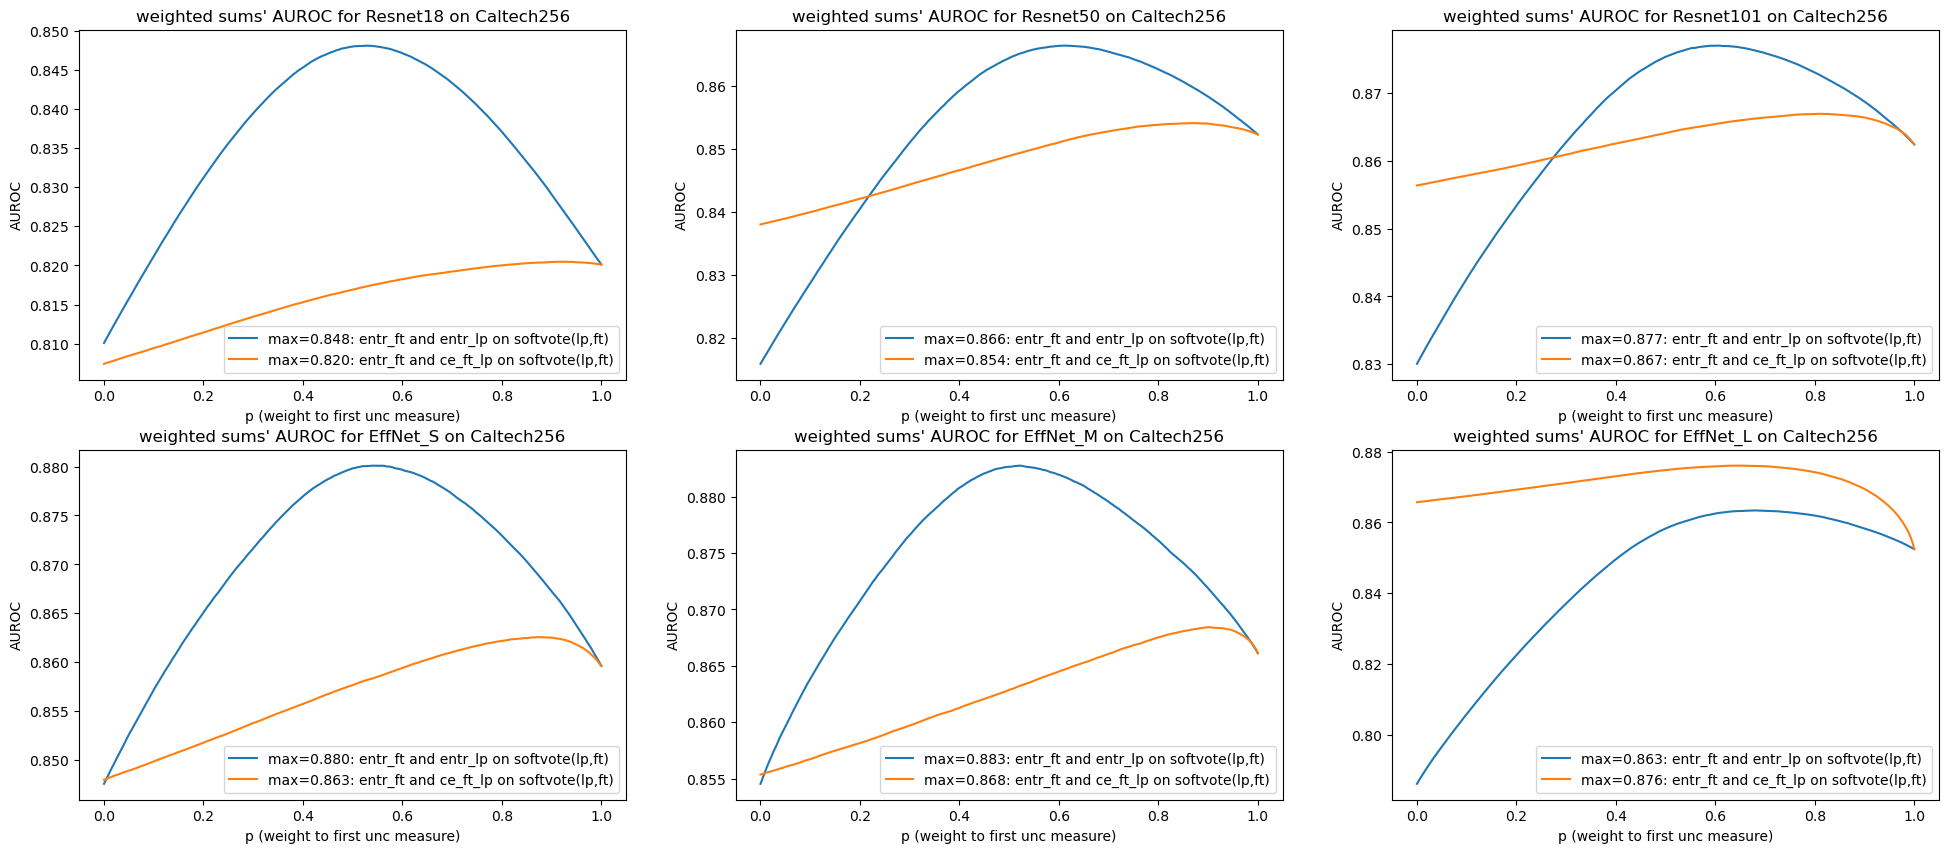

In [180]:
fig, axes = plt.subplots(nrow, ncol, figsize=(8*ncol, 5*nrow))
nsteps=500
evaluatee = "softvote(lp,ft)"
for i, model in enumerate(model_ls):
    pred_df = pd.read_csv(f"{pred_out_prefix}{dataset}_{model}.csv", index_col="Unnamed: 0")
    unc_df = pd.read_csv(f"{unc_out_prefix}{dataset}_{model}.csv", index_col="Unnamed: 0")
    ax = axes[i // ncol, i % ncol]
    ax.set_title(f"weighted sums' AUROC for {model} on {dataset}")
    
    opt_p_lpv = explore_weighted_sum(nsteps, unc_df, "entr_ft","entr_lp",pred_df,evaluatee,"target",ax)
    unc_df["opt_entr(lp)+entr(ft)_for_sv(lp,ft)"] = opt_p_lpv*unc_df['entr_ft']+(1-opt_p_lpv)*unc_df["entr_lp"]
    
    opt_p_entr_ce_lpv = explore_weighted_sum(nsteps, unc_df, "entr_ft","ce_ft_lp",pred_df,evaluatee,"target",ax)
    unc_df["opt_entr_lp_plus_ce_ft_lp_for_sv(lp,ft)"] = opt_p_entr_ce_lpv*unc_df['entr_ft']+(1-opt_p_entr_ce_lpv)*unc_df["ce_ft_lp"]
    
    # opt_p_entr_t_ce_pred_ft = explore_weighted_prod(nsteps, unc_df, "entr_ft","ce_ft_lp",pred_df,evaluatee,"target",ax)
    # unc_df["opt_entr_ft_times_ce_ft_lp_for_sv(lp,ft)"] = (unc_df['entr_ft']**opt_p_entr_t_ce_pred_ft)*(unc_df["ce_ft_lp"]**(1-opt_p_entr_t_ce_pred_ft))
    
    unc_df.to_csv(f"{unc_out_prefix}{dataset}_{model}.csv")
plt.show()

In [181]:
# fig, axes = plt.subplots(nrow, ncol, figsize=(8*ncol, 5*nrow))
# nsteps=500
# evaluatee = "top_3_ft"
# for i, model in enumerate(model_ls):
#     pred_df = pd.read_csv(f"{pred_out_prefix}{dataset}_{model}.csv", index_col="Unnamed: 0")
#     unc_df = pd.read_csv(f"{unc_out_prefix}{dataset}_{model}.csv", index_col="Unnamed: 0")
#     ax = axes[i // ncol, i % ncol]
#     ax.set_title(f"weighted sums' AUROC for {model} on {dataset}")
    
#     opt_p_lpv = explore_weighted_sum(nsteps, unc_df, "entr_ft","entr_lp",pred_df,evaluatee,"target",ax)
#     # unc_df["opt_entr(lp)+entr(ft)_for_{evaluatee}"] = opt_p_lpv*unc_df['entr_ft']+(1-opt_p_lpv)*unc_df["entr_lp"]
    
#     opt_p_entr_ce_lpv = explore_weighted_sum(nsteps, unc_df, "entr_ft","ce_ft_lp",pred_df,evaluatee,"target",ax)
#     # unc_df["opt_entr_lp_plus_ce_ft_lp_for_{evaluatee}"] = opt_p_entr_ce_lpv*unc_df['entr_ft']+(1-opt_p_entr_ce_lpv)*unc_df["ce_ft_lp"]
    
#     # opt_p_entr_t_ce_pred_ft = explore_weighted_prod(nsteps, unc_df, "entr_ft","ce_ft_lp",pred_df,evaluatee,"target",ax)
#     # unc_df["opt_entr_ft_times_ce_ft_lp_for_{evaluatee}"] = (unc_df['entr_ft']**opt_p_entr_t_ce_pred_ft)*(unc_df["ce_ft_lp"]**(1-opt_p_entr_t_ce_pred_ft))
    
#     unc_df.to_csv(f"{unc_out_prefix}{dataset}_{model}.csv")
# plt.show()

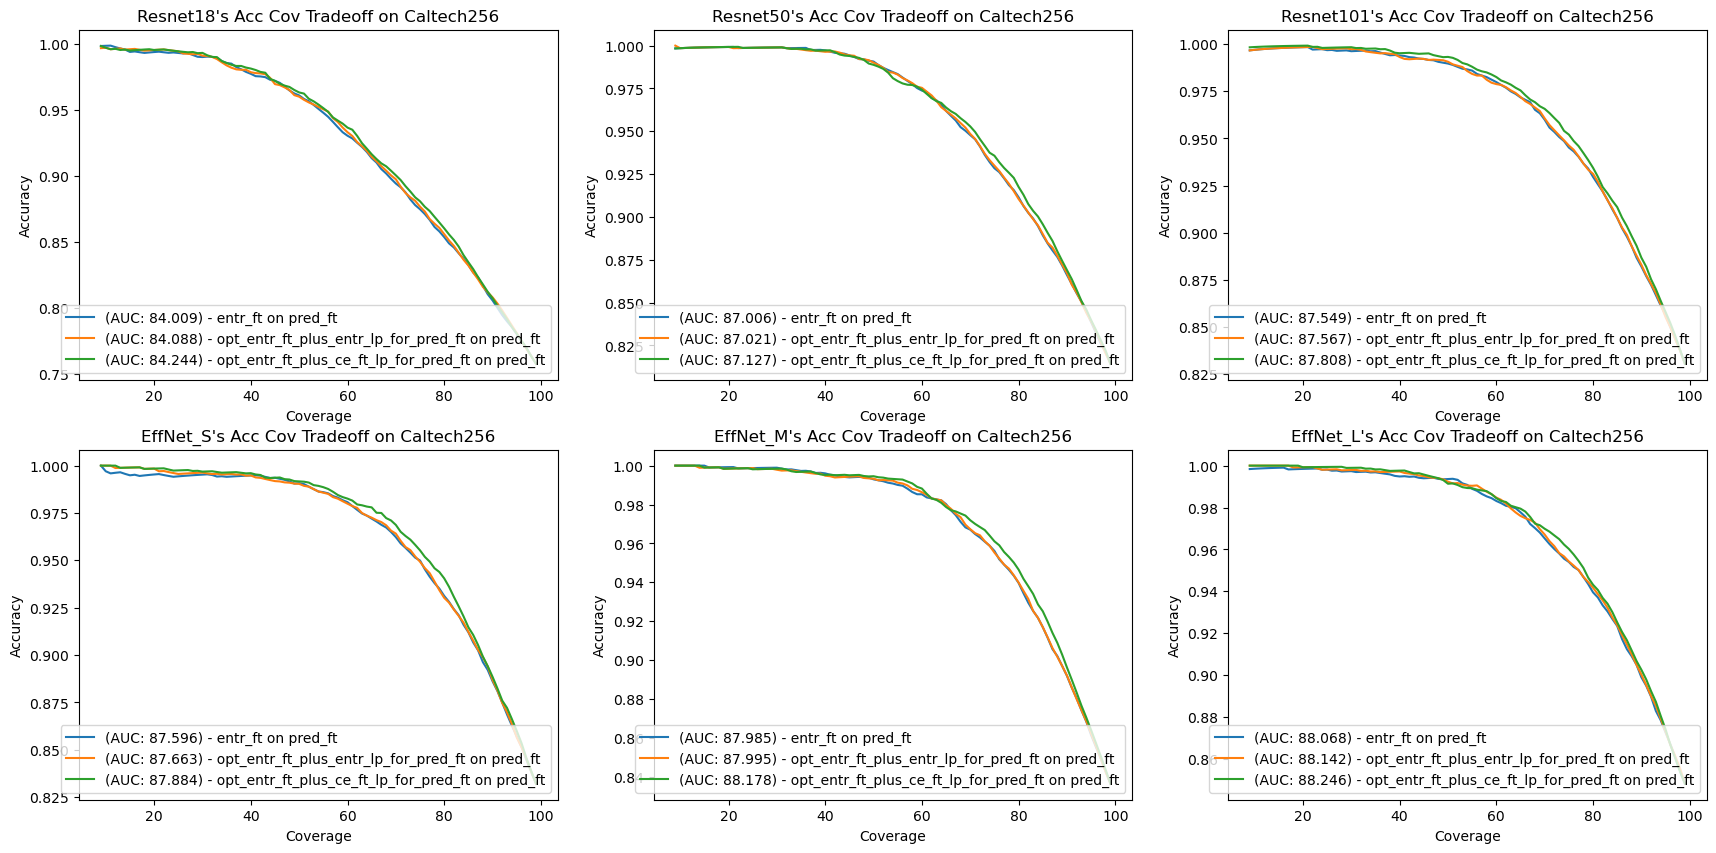

In [182]:
def get_rank(unc_pred):
    rank = pd.DataFrame()
    for curr_metric in unc_pred.columns:
        rank[curr_metric] = unc_pred[curr_metric].rank()
    return rank

def acc_cov_tradeoff(pred_df, pred_vec, target_vec, unc_vec, rank, ax, cov_range):
    temp=pd.DataFrame()
    temp["coverage"] = cov_range
    coverage_ls = (cov_range+1)/100*pred.shape[0]
    for i, cov in enumerate(coverage_ls):
        cov_pred = pred_df[rank[unc_vec]<cov]
        temp.loc[i,"acc"] = np.mean(cov_pred[pred_vec]==cov_pred[target_vec])
    area=np.sum(temp["acc"])
    label = f"(AUC: {area:.3f}) - {unc_vec} on {pred_vec}"
    sns.lineplot(temp,x="coverage",y="acc",label=label,ax = ax)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Coverage')
    ax.legend(loc = 'lower right')
    
cov_range = np.arange(9,100)
fig, axes = plt.subplots(nrow, ncol, figsize=(7*ncol, 5*nrow))
for i, model in enumerate(model_ls):
    ax = axes[i // ncol, i % ncol]
    ax.set_title(f"{model}'s Acc Cov Tradeoff on {dataset}")
    pred = pd.read_csv(f"{pred_out_prefix}{dataset}_{model}.csv", index_col="Unnamed: 0")
    unc_pred = pd.read_csv(f"{unc_out_prefix}{dataset}_{model}.csv", index_col="Unnamed: 0")
    rank=get_rank(unc_pred)
    acc_cov_tradeoff(pred, "pred_ft", "target", "entr_ft", rank, ax, cov_range)
    acc_cov_tradeoff(pred, "pred_ft", "target", "opt_entr_ft_plus_entr_lp_for_pred_ft", rank, ax, cov_range)
    acc_cov_tradeoff(pred, "pred_ft", "target", "opt_entr_ft_plus_ce_ft_lp_for_pred_ft", rank, ax, cov_range)
    # acc_cov_tradeoff(pred, "pred_ft", "target", "opt_entr_ft_times_ce_ft_lp_for_pred_ft", rank, ax, cov_range)

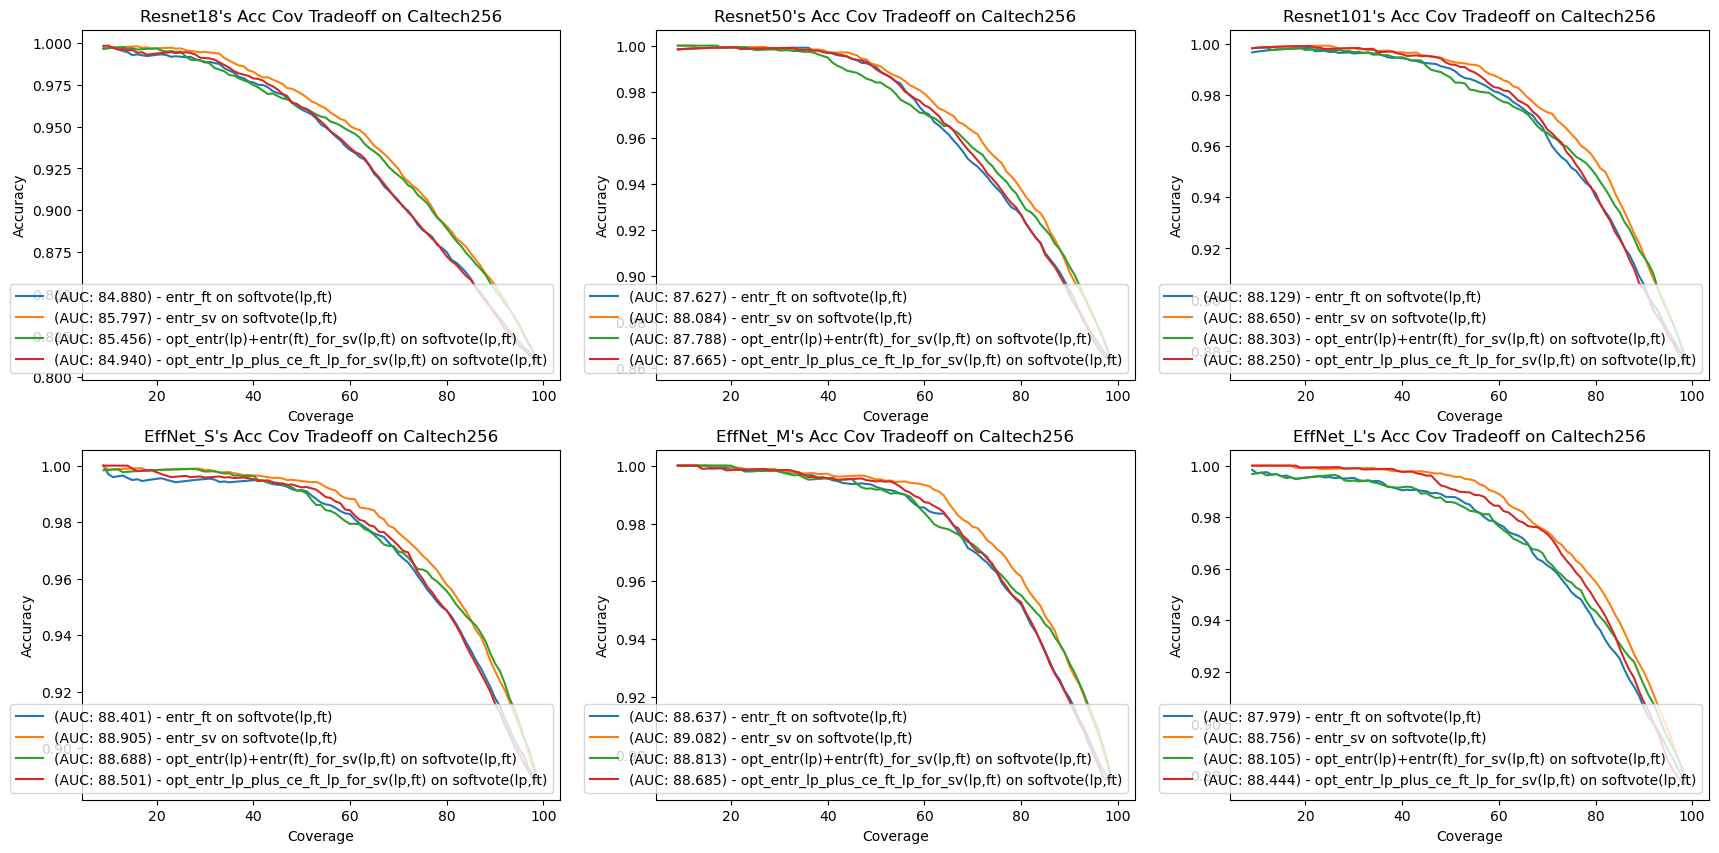

In [183]:
cov_range = np.arange(9,100)
fig, axes = plt.subplots(nrow, ncol, figsize=(7*ncol, 5*nrow))
for i, model in enumerate(model_ls):
    ax = axes[i // ncol, i % ncol]
    ax.set_title(f"{model}'s Acc Cov Tradeoff on {dataset}")
    pred = pd.read_csv(f"{pred_out_prefix}{dataset}_{model}.csv", index_col="Unnamed: 0")
    unc_pred = pd.read_csv(f"{unc_out_prefix}{dataset}_{model}.csv", index_col="Unnamed: 0")
    # display(unc_pred.head(1))
    rank=get_rank(unc_pred)
    acc_cov_tradeoff(pred, "softvote(lp,ft)", "target", "entr_ft", rank, ax, cov_range)
    acc_cov_tradeoff(pred, "softvote(lp,ft)", "target", "entr_sv", rank, ax, cov_range)
    # acc_cov_tradeoff(pred, "pred_ft", "target", "ce_ft_lp", rank, ax, cov_range)
    acc_cov_tradeoff(pred, "softvote(lp,ft)", "target", "opt_entr(lp)+entr(ft)_for_sv(lp,ft)", rank, ax, cov_range)
    acc_cov_tradeoff(pred, "softvote(lp,ft)", "target", "opt_entr_lp_plus_ce_ft_lp_for_sv(lp,ft)", rank, ax, cov_range)
    # acc_cov_tradeoff(pred, "softvote(lp,ft)", "target", "opt_entr_ft_times_ce_ft_lp_for_sv(lp,ft)", rank, ax, cov_range)

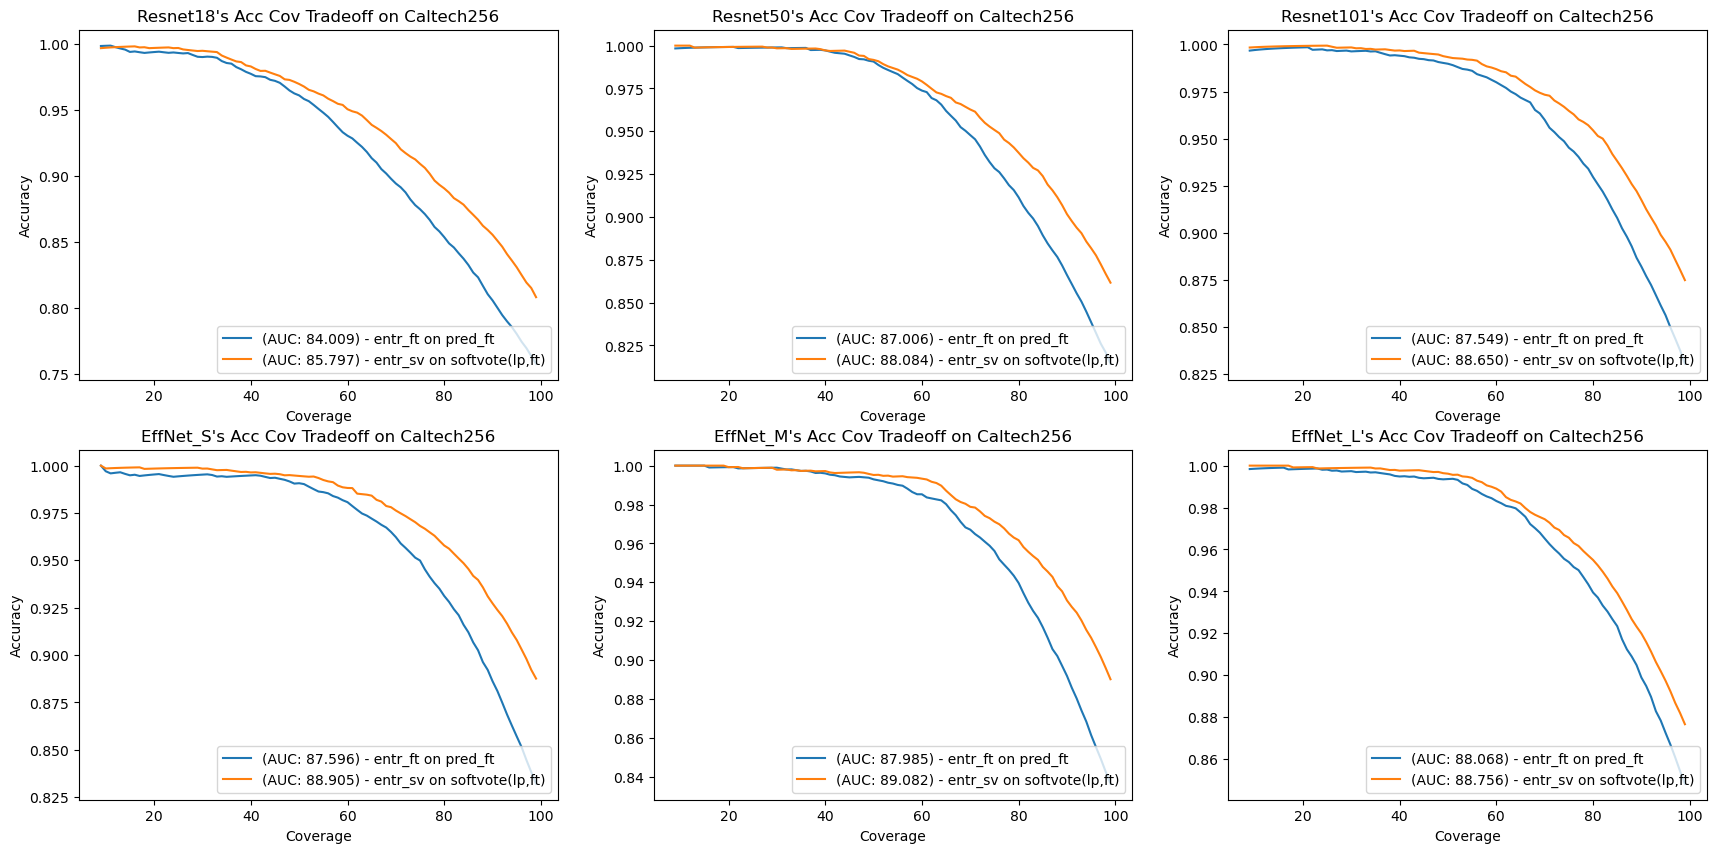

In [184]:
cov_range = np.arange(9,100)
fig, axes = plt.subplots(nrow, ncol, figsize=(7*ncol, 5*nrow))
for i, model in enumerate(model_ls):
    ax = axes[i // ncol, i % ncol]
    ax.set_title(f"{model}'s Acc Cov Tradeoff on {dataset}")
    pred = pd.read_csv(f"{pred_out_prefix}{dataset}_{model}.csv", index_col="Unnamed: 0")
    unc_pred = pd.read_csv(f"{unc_out_prefix}{dataset}_{model}.csv", index_col="Unnamed: 0")
    rank=get_rank(unc_pred)
    # acc_cov_tradeoff(pred, "pred_lp", "target", "entr_lp", rank, ax, cov_range)
    acc_cov_tradeoff(pred, "pred_ft", "target", "entr_ft", rank, ax, cov_range)
    acc_cov_tradeoff(pred, "softvote(lp,ft)", "target", "entr_sv", rank, ax, cov_range)
    # acc_cov_tradeoff(pred, "softvote(lp,ft)", "target", "entr_ft", rank, ax, cov_range)
    # acc_cov_tradeoff(pred, "softvote(lp,ft)", "target", "entr_ft+js", rank, ax, cov_range)

In [185]:
unc1 = "entr_ft"
# unc2 = "opt_entr_ft_plus_ce_ft_lp_for_pred_ft"
unc2 = "entr_ft+ce_ft_lp"
# unc2 = "opt_entr(lp)+entr(ft)_for_sv(lp,ft)"
# unc2 = "entr_ft*ce_ft_lp"
# unc2 = "entr_lp"
# unc2 = "entr_ft+ce_ft_lp"
evaluatee = "softvote(lp,ft)"
# evaluatee = "pred_ft"

In [186]:
# unc_pred.head()

Regression line for correct predictions: y = 2.39x + 0.17
Regression line for incorrect predictions: y = 2.00x + 1.17
Regression line for correct predictions: y = 2.62x + 0.16
Regression line for incorrect predictions: y = 2.21x + 1.04
Regression line for correct predictions: y = 2.71x + 0.11
Regression line for incorrect predictions: y = 2.23x + 1.09
Regression line for correct predictions: y = 2.65x + 0.13
Regression line for incorrect predictions: y = 2.06x + 1.33
Regression line for correct predictions: y = 2.75x + 0.19
Regression line for incorrect predictions: y = 2.13x + 1.34
Regression line for correct predictions: y = 2.91x + 0.44
Regression line for incorrect predictions: y = 1.77x + 3.77


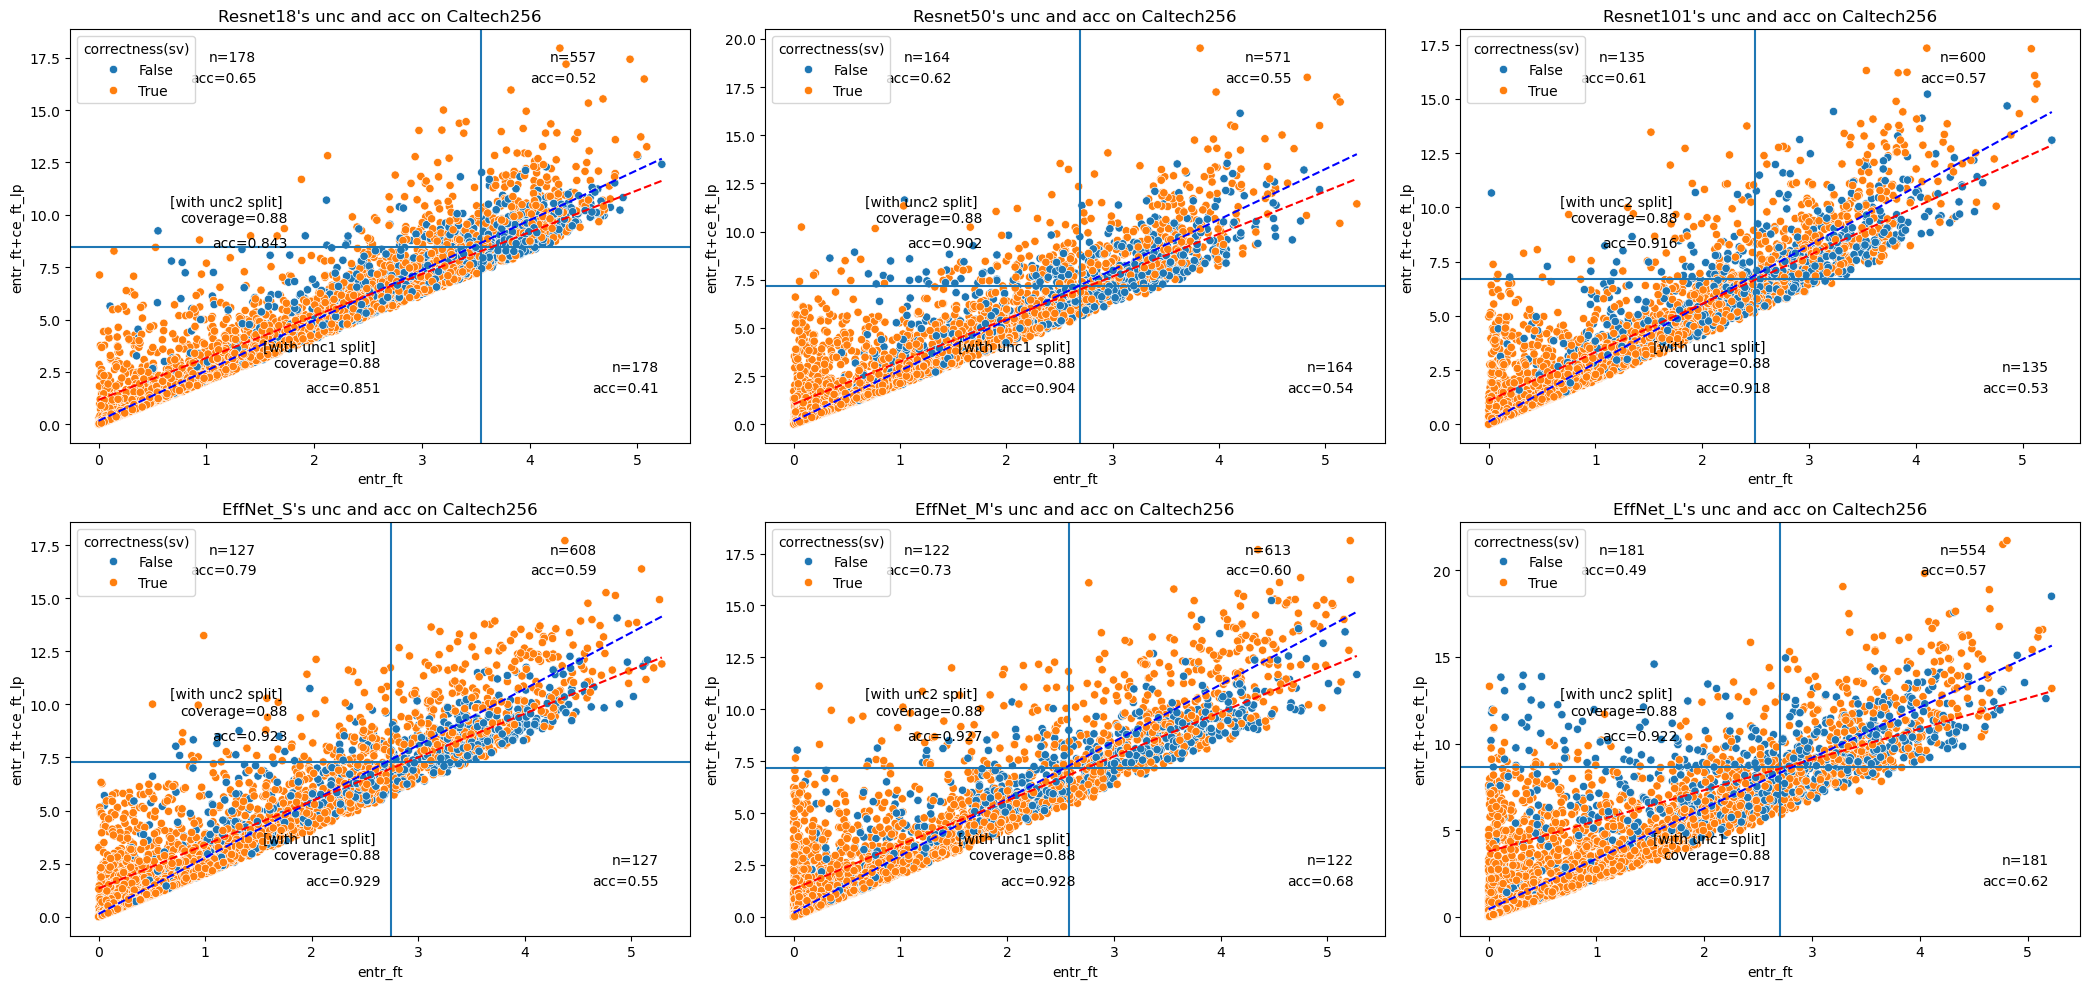

In [187]:
# model_ls = ["Resnet50"]
# cov_range = np.arange(9,100)
fig, axes = plt.subplots(nrow, ncol, figsize=(7*ncol, 5*nrow))
quantile=88
for i, model in enumerate(model_ls):
    ax = axes[i // ncol, i % ncol]
    ax.set_title(f"{model}'s unc and acc on {dataset}")
    pred = pd.read_csv(f"{pred_out_prefix}{dataset}_{model}.csv", index_col="Unnamed: 0")
    unc_pred = pd.read_csv(f"{unc_out_prefix}{dataset}_{model}.csv", index_col="Unnamed: 0")
    unc_1_threshold = np.percentile(a=unc_pred[unc1],q=quantile)
    unc_2_threshold = np.percentile(a=unc_pred[unc2],q=quantile)
    
    unc_1_edge = pred[(unc_pred[unc1] > unc_1_threshold) & (unc_pred[unc2] < unc_2_threshold)]
    unc_pred[f"{unc1}_edge"]=(unc_pred[unc1] > unc_1_threshold) & (unc_pred[unc2] < unc_2_threshold)
    unc_2_edge = pred[(unc_pred[unc2] > unc_2_threshold) & (unc_pred[unc1] < unc_1_threshold)]
    unc_pred[f"{unc2}_edge"]=(unc_pred[unc2] > unc_2_threshold) & (unc_pred[unc1] < unc_1_threshold)
    unc_1_unc_2_joint = pred[(unc_pred[unc1] >= unc_1_threshold) & (unc_pred[unc2] >= unc_2_threshold)]
    unc_pred[f"{unc1}_{unc2}_joint"]=(unc_pred[unc1] >= unc_1_threshold) & (unc_pred[unc2] >= unc_2_threshold)
    covered_unc_1 = pred[(unc_pred[unc1] <= unc_1_threshold)]
    covered_unc_2 = pred[(unc_pred[unc2] <= unc_2_threshold)]
    
    unc_1_edge_acc = np.mean(unc_1_edge[evaluatee]==unc_1_edge["target"])
    unc_2_edge_acc = np.mean(unc_2_edge[evaluatee]==unc_2_edge["target"])
    unc_1_unc_2_joint_acc = np.mean(unc_1_unc_2_joint[evaluatee]==unc_1_unc_2_joint["target"])
    covered_acc_unc_1 = np.mean(covered_unc_1[evaluatee]==covered_unc_1["target"])
    covered_acc_unc_2 = np.mean(covered_unc_2[evaluatee]==covered_unc_2["target"])
    unc_pred["correctness(sv)"] = pred[evaluatee]==pred["target"]
    sns.scatterplot(data=unc_pred,x=unc1,y=unc2,hue="correctness(sv)",ax=ax)
    ax.axvline(unc_1_threshold,)
    ax.axhline(unc_2_threshold) 
    size_unc1_edge, size_unc2_edge, size_unc1_2_joint, coverage_unc_1, coverage_unc_2 = unc_1_edge.shape[0], unc_2_edge.shape[0], unc_1_unc_2_joint.shape[0], covered_unc_1.shape[0]/pred.shape[0], covered_unc_2.shape[0]/pred.shape[0]
    ax.text(0.95, 0.20, f"n={size_unc1_edge}", transform=ax.transAxes, ha='right', va='top')
    ax.text(0.95, 0.15, f"acc={unc_1_edge_acc:.2f}", transform=ax.transAxes, ha='right', va='top')
    ax.text(0.3, 0.95, f"n={size_unc2_edge}", transform=ax.transAxes, ha='right', va='top')
    ax.text(0.3, 0.9, f"acc={unc_2_edge_acc:.2f}", transform=ax.transAxes, ha='right', va='top')
    ax.text(0.85, 0.95, f"n={size_unc1_2_joint}", transform=ax.transAxes, ha='right', va='top')
    ax.text(0.85, 0.9, f"acc={unc_1_unc_2_joint_acc:.2f}", transform=ax.transAxes, ha='right', va='top')
    ax.text(0.5, 0.25, f"[with unc1 split] \ncoverage={coverage_unc_1:.2f}", transform=ax.transAxes, ha='right', va='top')
    ax.text(0.5, 0.15, f"acc={covered_acc_unc_1:.3f}", transform=ax.transAxes, ha='right', va='top')
    ax.text(0.35, 0.6, f"[with unc2 split] \ncoverage={coverage_unc_2:.2f}", transform=ax.transAxes, ha='right', va='top')
    ax.text(0.35, 0.5, f"acc={covered_acc_unc_2:.3f}", transform=ax.transAxes, ha='right', va='top')
    
    # Linear regression for correct predictions
    correct_predictions = unc_pred[unc_pred["correctness(sv)"]]
    X_correct = correct_predictions[unc1].values.reshape(-1, 1)
    y_correct = correct_predictions[unc2].values
    reg_correct = LinearRegression().fit(X_correct, y_correct)
    
    # Linear regression for incorrect predictions
    incorrect_predictions = unc_pred[~unc_pred["correctness(sv)"]]
    X_incorrect = incorrect_predictions[unc1].values.reshape(-1, 1)
    y_incorrect = incorrect_predictions[unc2].values
    reg_incorrect = LinearRegression().fit(X_incorrect, y_incorrect)

    # Plotting regression lines
    x_range = np.linspace(unc_pred[unc1].min(), unc_pred[unc1].max(), 100).reshape(-1, 1)
    ax.plot(x_range, reg_correct.predict(x_range), color='blue', linestyle='--', label='Correct')
    ax.plot(x_range, reg_incorrect.predict(x_range), color='red', linestyle='--', label='Incorrect')

    print(f"Regression line for correct predictions: y = {reg_correct.coef_[0]:.2f}x + {reg_correct.intercept_:.2f}")
    print(f"Regression line for incorrect predictions: y = {reg_incorrect.coef_[0]:.2f}x + {reg_incorrect.intercept_:.2f}")

    
    unc_pred.to_csv(f"{unc_out_prefix}{dataset}_{model}.csv")
plt.tight_layout()

acc_outlier=0.744
acc_inlier=0.989
curr_cov=0.542


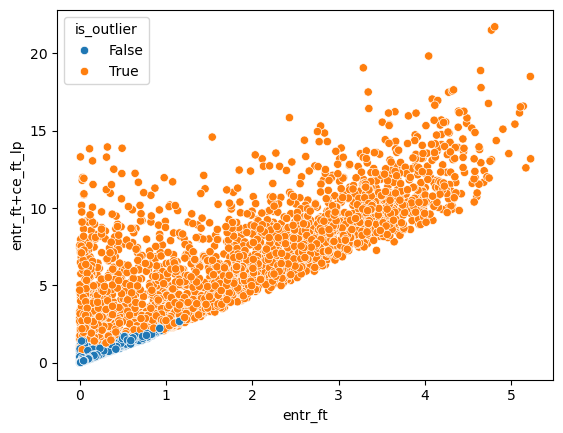

In [188]:
clustering = DBSCAN(eps=0.055, min_samples=12).fit(unc_pred[[unc1,unc2]])
res = clustering.labels_
# res = LocalOutlierFactor(n_neighbors=300,algorithm="brute").fit_predict(unc_pred[[unc1,unc2]])

unc_pred["is_outlier"] = (res==-1)
unc_pred["is_outlier"] = unc_pred.apply(lambda row: row["is_outlier"], axis=1)
sns.scatterplot(data=unc_pred,x=unc1,y=unc2,hue="is_outlier")
outlier_subset = pred[unc_pred["is_outlier"]==True]
inlier_subset = pred[unc_pred["is_outlier"]==False]
# display(outlier_subset)
acc_outlier = np.mean(outlier_subset[evaluatee]==outlier_subset["target"])
acc_inlier = np.mean(inlier_subset[evaluatee]==inlier_subset["target"])
curr_cov = inlier_subset.shape[0]/pred.shape[0]
print(f"{acc_outlier=:.3f}")
print(f"{acc_inlier=:.3f}")
print(f"{curr_cov=:.3f}")

In [189]:

random_state = 42 # For reproducibility
test_transform_routine = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for resnets
    transforms.Lambda(lambda x: x.convert('RGB')),  # Convert to three channels
    transforms.ToTensor(),  # Transform to tensor for torch
])
# Path to the extracted Caltech256 caltech256
caltech256_path = "data/caltech256"
# Load the caltech256
caltech256 = ImageFolder(root=caltech256_path, transform=test_transform_routine)
train_idx, test_idx = train_test_split(list(range(len(caltech256))), test_size=0.4, random_state=random_state)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, random_state=random_state)
train = Subset(caltech256, train_idx)
val = Subset(caltech256, val_idx)
test = Subset(caltech256, test_idx)

In [190]:
# Function to display images in a grid
def imshow(img):
    npimg = img.numpy()
    plt.imshow(npimg)
    plt.show()

# Display images in a grid
def show_images(images, n_row, n_col, pred_sub, unc_sub):
    fig, axes = plt.subplots(n_row, n_col, figsize=(16, 16))
    for i in range(n_row):
        for j in range(n_col):
            index = i * n_col + j
            if index < len(images):
                img = images[index]
                npimg = img.numpy()
                axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
                axes[i, j].axis('off')
                target = pred_sub.iloc[index]["target_label"]
                lp_pred = pred_sub.iloc[index]["pred_lp_label"]
                ft_pred = pred_sub.iloc[index]["pred_ft_label"]
                sv_pred = pred_sub.iloc[index]["softvote_label"]
                curr_entr_ft = unc_sub.iloc[index]["entr_ft"]
                curr_entr_lp = unc_sub.iloc[index]["entr_lp"]
                axes[i, j].text(0, -130, f"True: {target}", fontsize=8, color='black')
                axes[i, j].text(0, -50, f"ft: {ft_pred} - entr(ft)={curr_entr_ft:.2f}", fontsize=8, color='green' if ft_pred==target else "red")
                axes[i, j].text(0, -90, f"lp: {lp_pred} - entr(lp)={curr_entr_lp:.2f}", fontsize=8, color='green' if lp_pred==target else "red")
                axes[i, j].text(0, -10, f"SV: {sv_pred}", fontsize=8, color='green' if sv_pred==target else "red")
            else:
                axes[i, j].axis('off')
    plt.subplots_adjust(wspace=0.5, hspace=1)
    plt.show()


In [191]:
# outlier_indices = np.where(unc_pred["is_outlier"].values == True)[0]
# outlier_subset = Subset(test, outlier_indices)

# # DataLoader for the outlier subset
# outlier_loader = DataLoader(outlier_subset, batch_size=64, shuffle=False)

# caltech256 = ImageFolder(root="data/256_ObjectCategories")
# class_labels = caltech256.classes
# class_labels = [label.split('.', 1)[1] for label in class_labels]
# pred_sub = pred.loc[outlier_indices]
# pred_sub['pred_ft_label'] = pred_sub['pred_ft'].apply(lambda x: class_labels[x])
# pred_sub['pred_lp_label'] = pred_sub['pred_lp'].apply(lambda x: class_labels[x])
# pred_sub['target_label'] = pred_sub['target'].apply(lambda x: class_labels[x])
# pred_sub['softvote_label'] = pred_sub['softvote(lp,ft)'].apply(lambda x: class_labels[x])
# unc_sub = unc_pred.iloc[outlier_indices]

In [192]:
# prev_bs = 0
# for i, (images, labels) in enumerate(outlier_loader):
#     bs = len(images)
#     print(f"Batch size: {bs}")
#     print(i)
#     pred_sub_batch = pred_sub.iloc[i*prev_bs:]  # Select the current batch from pred_sub
#     unc_sub_batch = unc_sub.iloc[i*prev_bs:]
#     show_images(images, 8, 8, pred_sub_batch, unc_sub_batch)
#     prev_bs = bs

In [193]:
# model_to_display = "Resnet50"

# caltech256 = ImageFolder(root="data/caltech256/256_ObjectCategories")
# class_labels = caltech256.classes
# class_labels = [label.split('.', 1)[1] for label in class_labels]

# pred = pd.read_csv(f"{pred_out_prefix}{dataset}_{model_to_display}.csv", index_col="Unnamed: 0")
# unc_pred = pd.read_csv(f"{unc_out_prefix}{dataset}_{model_to_display}.csv", index_col="Unnamed: 0")
# display(pred.head(1))
# display(unc_pred.head(1))

# unc1_edge_indices = np.where((unc_pred[f"{unc1}_edge"].values == True) & (unc_pred["correctness(sv)"]==False))[0]
# unc2_edge_indices = np.where((unc_pred[f"{unc2}_edge"].values == True) & (unc_pred["correctness(sv)"]==False))[0]
# unc1_unc2_joint_indices = np.where((unc_pred[f"{unc1}_{unc2}_joint"].values == True) & (unc_pred["correctness(sv)"]==False))[0]
# unc1_unc2_missed_indices = np.where((unc_pred[f"{unc1}_{unc2}_joint"].values == False) & (unc_pred[f"{unc1}_edge"].values == False) & (unc_pred[f"{unc2}_edge"].values == False) & (unc_pred["correctness(sv)"]==False))[0]

# sample_n = 6
# sampled = np.concatenate((np.random.choice(unc1_edge_indices,sample_n,replace=True),
#                           np.random.choice(unc2_edge_indices,sample_n,replace=True),
#                           np.random.choice(unc1_unc2_joint_indices,sample_n,replace=True),
#                           np.random.choice(unc1_unc2_missed_indices,sample_n,replace=True)))
# print(sampled)

# pred_sub = pred.loc[sampled]
# unc_sub = unc_pred.iloc[sampled]
# pred_sub['pred_ft_label'] = pred_sub['pred_ft'].apply(lambda x: class_labels[x])
# pred_sub['pred_lp_label'] = pred_sub['pred_lp'].apply(lambda x: class_labels[x])
# pred_sub['target_label'] = pred_sub['target'].apply(lambda x: class_labels[x])
# pred_sub['softvote_label'] = pred_sub['softvote(lp,ft)'].apply(lambda x: class_labels[x])

# subset = Subset(test, sampled)
# subset_loader = DataLoader(subset, batch_size=32, shuffle=False)
# prev_bs=0
# for i, (images, labels) in enumerate(subset_loader):
#     bs = len(images)
#     print(f"Batch size: {bs}")
#     print(i)
#     pred_sub_batch = pred_sub.iloc[i*prev_bs:]  # Select the current batch from pred_sub
#     unc_sub_batch = unc_sub.iloc[i*prev_bs:]
#     show_images(images, 4,sample_n, pred_sub_batch, unc_sub_batch)
#     prev_bs = bs

In [194]:
# unc1_edge_indices = np.where((unc_pred[f"{unc1}_edge"].values == True) & (unc_pred["correctness(sv)"]==True))[0]
# unc2_edge_indices = np.where((unc_pred[f"{unc2}_edge"].values == True) & (unc_pred["correctness(sv)"]==True))[0]
# unc1_unc2_joint_indices = np.where((unc_pred[f"{unc1}_{unc2}_joint"].values == True) & (unc_pred["correctness(sv)"]==True))[0]
# unc1_unc2_missed_indices = np.where((unc_pred[f"{unc1}_{unc2}_joint"].values == False) & (unc_pred[f"{unc1}_edge"].values == False) & (unc_pred[f"{unc2}_edge"].values == False) & (unc_pred["correctness(sv)"]==True))[0]
# # print(f"{unc1_edge_indices=}\n{unc2_edge_indices=}\n{unc1_unc2_joint_indices=}\n{unc1_unc2_missed_indices=}")
# sample_n = 6
# sampled = np.concatenate((np.random.choice(unc1_edge_indices,sample_n,False),
#                           np.random.choice(unc2_edge_indices,sample_n,False),
#                           np.random.choice(unc1_unc2_joint_indices,sample_n,False),
#                           np.random.choice(unc1_unc2_missed_indices,sample_n,False)))
# print(sampled)

# pred_sub = pred.loc[sampled]
# unc_sub = unc_pred.iloc[sampled]
# pred_sub['pred_ft_label'] = pred_sub['pred_ft'].apply(lambda x: class_labels[x])
# pred_sub['pred_lp_label'] = pred_sub['pred_lp'].apply(lambda x: class_labels[x])
# pred_sub['target_label'] = pred_sub['target'].apply(lambda x: class_labels[x])
# pred_sub['softvote_label'] = pred_sub['softvote(lp,ft)'].apply(lambda x: class_labels[x])

# subset = Subset(test, sampled)
# subset_loader = DataLoader(subset, batch_size=32, shuffle=False)
# for i, (images, labels) in enumerate(subset_loader):
#     bs = len(images)
#     print(f"Batch size: {bs}")
#     print(i)
#     pred_sub_batch = pred_sub.iloc[i*prev_bs:]  # Select the current batch from pred_sub
#     unc_sub_batch = unc_sub.iloc[i*prev_bs:]
#     show_images(images, 4,sample_n, pred_sub_batch, unc_sub_batch)
#     prev_bs = bs